This notebook will explore how optimal entry points might cluster when taking different indicators into account.


In [1]:
import os
os.chdir('../../')
os.getcwd()

'/Users/rosscopeland/Desktop/personal/code/vivaldi/back_testing'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from v2.model import Trading
from v2.strategy.indicators.smma import SMMA
from v2.strategy.indicators.stochastic_oscillator import StochasticOscillator
from v2.strategy.indicators.bollinger_bands import BollingerBands
from v2.strategy.indicators.rsi import RSI
from v2.strategy.indicators.macd import MACD
from v2.strategy.indicators.param import Param



In [8]:
def load_config():
    my_config = {}
    with open('config.config') as config:
        for line in config:
            args = line.split('=')
            my_config[args[0]] = args[1].rstrip().split(',')
    return my_config

model = Trading(load_config())

In [9]:
datasets = model.dfs
appended_dataset = pd.DataFrame()
for d in datasets:
    print(d[1])
    training_set = d[0]
    training_set['trough'] = training_set.iloc[argrelextrema(training_set.close.values, np.less_equal, order=480)[0]]['close']
    training_set['peak'] = training_set.iloc[argrelextrema(training_set.close.values, np.greater_equal, order=480)[0]]['close']
    ema_fast = Param(5, 10000, 0, 'ema_fast', 60)
    ema_slow= Param(6, 10001, 0, 'ema_slow', 120)
    signal = Param(5, 10001, 0, 'signal', 90)
    macd_ = MACD(_params=[ema_fast, ema_slow, signal], _name='macd')
    macd_.genData(training_set, gen_new_values=False)
    boll_period = Param(5, 10000, 0, 'period', 90)
    boll_bands = BollingerBands(_params=[boll_period], _name='bollinger_bands')
    boll_bands.genData(training_set, gen_new_values=False)
    stoch_highlow = Param(5, 10000, 0, 'highlow_range', 90.0)
    stoch_k = Param(5, 10000, 0, 'k_period', 270.0)
    stoch_oscillator = StochasticOscillator(_params=[stoch_highlow, stoch_k], _name='stochastic_oscillator')
    stoch_oscillator.genData(training_set, gen_new_values=False)
    rsi_period = Param(5, 10000, 0, 'period', 90.0)
    rsi_ = RSI(_params=[rsi_period], _name='rsi')
    rsi_.genData(training_set, gen_new_values=False)
    smma_period = Param(5, 10000, 0, 'period', 90.0)
    smma_ = SMMA(_params=[smma_period], _name='smma')
    smma_.genData(training_set, gen_new_values=False)
    training_set[['trough', 'peak']] = training_set[['trough', 'peak']].fillna(0)
    training_set['slope'] = (training_set['close'].rolling(window=30).max() - training_set['close'].rolling(window=30).min()) / training_set['close'].rolling(window=30).max()
    training_set = training_set.dropna()
    appended_dataset = appended_dataset.append(training_set)


    

XDGUSD
BATUSD
OMGUSD
ZECUSD
DASHUSD
ETCUSD
DAIUSD
ATOMUSD
XLMUSD
XTZUSD
XMRUSD
XTZUSD
EOSUSD
ADAUSD
LTCUSD
BCHUSD
XRPUSD
ETHUSD
XBTUSD


In [34]:
clf = RandomForestClassifier(random_state=69420, max_features=None, criterion='gini', n_estimators=100, bootstrap=False, n_jobs=-1, min_samples_leaf=1)
# clf = MLPClassifier(random_state=69420, activation='tanh', shuffle=True)

trough_input_data = appended_dataset[['stosc_k', 'slope', 'macd_diff', 'rsi']]

is_trough = appended_dataset['trough'].gt(0).astype(int)
clf.fit(trough_input_data, is_trough)


RandomForestClassifier(bootstrap=False, max_features=None, n_jobs=-1,
                       random_state=69420)

In [48]:
clf_2 = RandomForestClassifier(random_state=69420, max_features=None, criterion='gini', n_estimators=100, bootstrap=False, n_jobs=-1, min_samples_leaf=1)
peak_input_data = appended_dataset[['stosc_k', 'slope', 'macd_diff', 'rsi']]
is_peak = appended_dataset['peak'].gt(0).astype(int)
clf_2.fit(peak_input_data, is_peak)

RandomForestClassifier(bootstrap=False, max_features=None, n_jobs=-1,
                       random_state=69420)

In [23]:
import pickle


In [55]:
trough_pred = clf.predict(new_input_data_trough)
print(trough_pred)
# temp_prob = [x[1] for x in clf.predict_proba(new_input_data_trough)]
# print(temp_prob)
# print(trough_pred)
# for trough in trough_pred:
#     if trough[1] < trough[0]:
#         continue
#     else:
#         print(trough)

[0 0 0 ... 0 0 0]


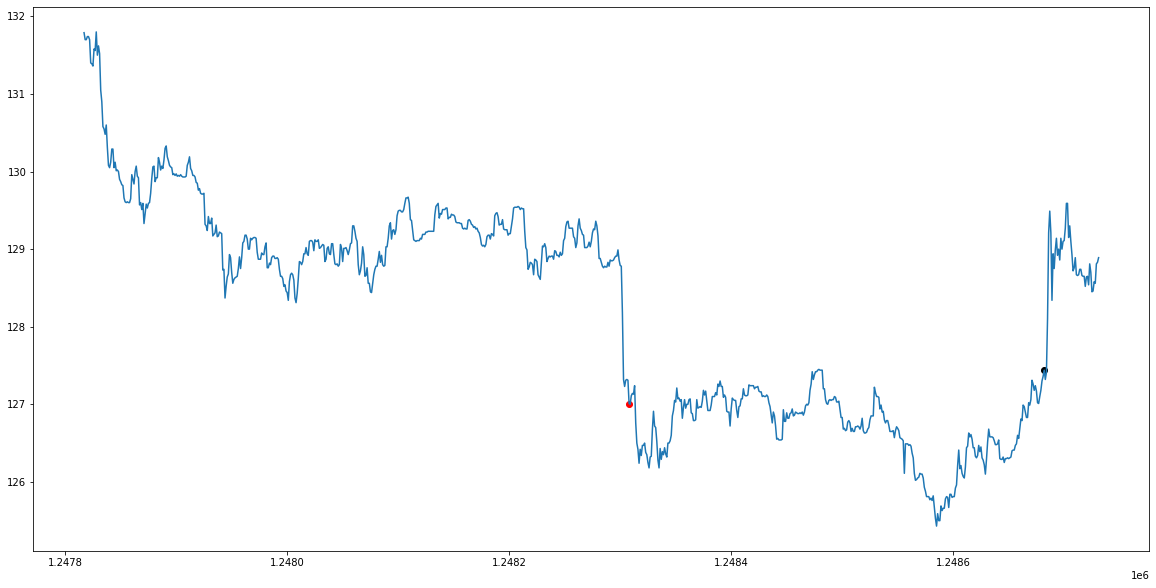

In [64]:
model = Trading(load_config())
datasets = model.dfs
test_data = datasets[0][0]

macd_.genData(test_data, gen_new_values=False)

boll_bands.genData(test_data, gen_new_values=False)

stoch_oscillator.genData(test_data, gen_new_values=False)

rsi_.genData(test_data, gen_new_values=False)
test_data['slope'] = (test_data['close'].rolling(window=10).max() - test_data['close'].rolling(window=10).min()) / test_data['close'].rolling(window=10).max()
test_data = test_data.dropna()

new_input_data_trough = test_data[['stosc_k', 'slope', 'macd_diff', 'rsi']]
new_input_data_peak = test_data[['stosc_k', 'slope', 'macd_diff', 'rsi']]

test_data['predictions_trough'] = clf.predict(new_input_data_trough)
test_data['predictions_peak'] = clf_2.predict(new_input_data_peak)

def insert_predictions(close, prediction, heat_val):
    if prediction:# and heat_val > 0.6:
        return close
    else:
        return None

model = pickle.load(open("v2/strategy/saved_models/troughs_3tree_big_data.sav", "rb"))
troughs = model.predict(new_input_data_trough)

temp_prob = [x[1] for x in clf.predict_proba(new_input_data_trough)]
temp_prob_df = pd.DataFrame(temp_prob, columns=["heat_val"])
test_data['pred_heat_val'] = temp_prob
test_data['pred_heat_val'] = test_data['pred_heat_val'].astype(float)
test_data['pred_heat_val'] = troughs


temp_prob_peak = [x[1] for x in clf_2.predict_proba(new_input_data_trough)]
temp_prob_peak_df = pd.DataFrame(temp_prob, columns=["heat_val"])
test_data['pred_peak_val'] = temp_prob_peak
test_data['pred_peak_val'] = test_data['pred_peak_val'].astype(float)

test_data['predictions_trough'] = test_data.apply(lambda row: insert_predictions(row['close'], row['predictions_trough'], row["pred_heat_val"]), axis=1)



# test_data['pred_heat_val'] = pd.DataFrame(temp_prob['teams'].to_list(), columns=['team1','team2'])
test_data['predictions_peak'] = test_data.apply(lambda row: insert_predictions(row['close'], row['predictions_peak'], row['pred_peak_val']), axis=1)
plt.figure(figsize=(20,10))
# print(test_data['pred_heat_val'])
plt.scatter(test_data.index, test_data['predictions_trough'], c='r')#, alpha=test_data["pred_heat_val"])
plt.scatter(test_data.index, test_data['predictions_peak'], c='black')
plt.plot(test_data.index, test_data['close'])
plt.show()


In [37]:
pickle.dump(clf, open('troughs_100tree_big_data.sav', 'wb'))
# pickle.dump(clf, open('peaks_3t', 'wb'))

In [77]:

t = test_data["predictions_trough"].dropna()
r = test_data.loc[test_data['close'] == 127.01]
r

,time,open,high,low,close,volume,trades,ema_slow,ema_fast,macd,...,rsi_u,rsi_d,rsi_smma_u,rsi_smma_d,rsi,slope,predictions_trough,predictions_peak,pred_heat_val,pred_peak_val
1248308,1577983920,127.30,127.30,127.01,127.01,29.439593,14,128.869937,128.650539,-0.219398,...,0.0,0.30,0.025623,0.047636,34.975484,0.014357,127.01,NaN,0,0.0
1248486,1578003120,127.01,127.03,127.01,127.01,42.791965,5,127.117958,127.085211,-0.032748,...,0.0,0.05,0.030616,0.033493,47.756735,0.003452,NaN,NaN,0,0.0
1248677,1578025440,127.01,127.01,127.01,127.01,0.031467,1,126.538549,126.652781,0.114232,...,0.0,0.01,0.036592,0.031688,53.591079,0.002514,NaN,NaN,0,0.0
